In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image

# from IPython.core.interactiveshell import InteractiveShell


In [2]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
classifier_url ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)
classfier = keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [5]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

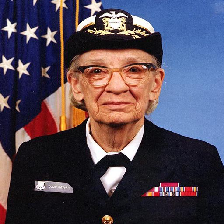

In [6]:
grace_hopper = keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper

array([[[0.09803922, 0.10980392, 0.3254902 ],
        [0.11764706, 0.1254902 , 0.36470588],
        [0.12941176, 0.13333333, 0.39607843],
        ...,
        [0.28627451, 0.43529412, 0.72941176],
        [0.25882353, 0.40784314, 0.70196078],
        [0.21960784, 0.36862745, 0.6627451 ]],

       [[0.09803922, 0.10980392, 0.3254902 ],
        [0.09411765, 0.10196078, 0.34117647],
        [0.09019608, 0.09411765, 0.34901961],
        ...,
        [0.30588235, 0.44705882, 0.7372549 ],
        [0.31764706, 0.45882353, 0.74901961],
        [0.3372549 , 0.47843137, 0.76862745]],

       [[0.08235294, 0.09411765, 0.30980392],
        [0.09019608, 0.09803922, 0.3372549 ],
        [0.11372549, 0.11764706, 0.37254902],
        ...,
        [0.36078431, 0.50588235, 0.78431373],
        [0.31764706, 0.4627451 , 0.74117647],
        [0.3254902 , 0.47058824, 0.74901961]],

       ...,

       [[0.63529412, 0.03921569, 0.09019608],
        [0.64705882, 0.07058824, 0.10980392],
        [0.59607843, 0

In [8]:
result = classfier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [9]:
result

array([[ 0.17920226,  1.2696196 , -0.3149811 , ...,  0.6060531 ,
        -0.4299785 ,  0.1120017 ]], dtype=float32)

In [10]:
predicted_class = np.argmax(result)
predicted_class

653

In [11]:
labels_path = keras.utils.get_file('ImageNetLabels.txt',
                                   'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


Text(0.5, 1.0, 'Prediction: Military Uniform')

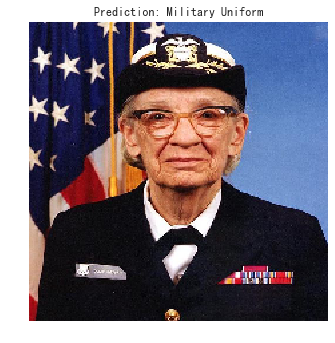

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title())


In [13]:
# 花数据
data_root = keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [14]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [15]:
image_data

In [16]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [17]:
result_batch = classfier.predict(image_batch)
result_batch.shape

(32, 1001)

In [18]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['comic book', 'mushroom', "yellow lady's slipper", 'barn spider',
       'daisy', 'daisy', 'daisy', 'daisy', 'swab', 'daisy', 'daisy',
       'sea anemone', 'rapeseed', 'goldfish', 'sea urchin',
       'picket fence', 'pitcher', 'parachute', 'daisy', 'daisy', 'pot',
       'hay', 'daisy', 'corn', 'coral fungus', 'daisy', 'mask',
       'coral reef', 'toyshop', 'vase', 'plastic bag', 'sea urchin'],
      dtype='<U30')

Text(0.5, 0.98, 'ImageNet predictions')

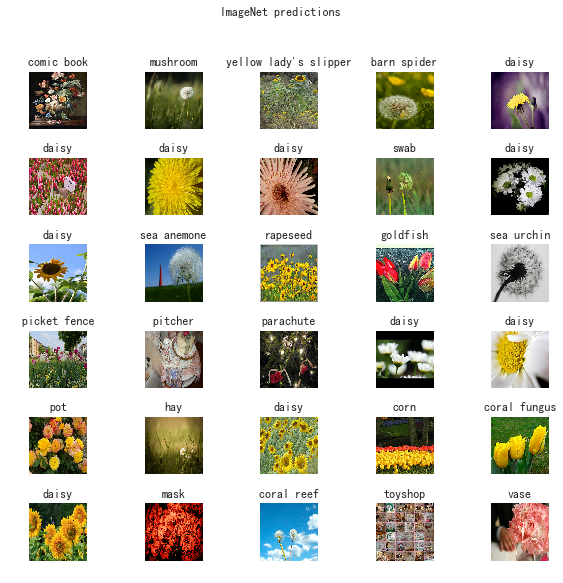

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
plt.suptitle("ImageNet predictions")

In [25]:
feature_extractor_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [26]:
# 每一张图片转化成1280维的向量
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [27]:
# 在特征提取的过程中冻结变量,以便在训练过程中只修改新的分类层
feature_extractor_layer.trainable = False


In [28]:
model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [30]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [31]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [32]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit(image_data, 
          epochs=2, 
          steps_per_epoch=steps_per_epoch, 
          callbacks=[batch_stats_callback])

Epoch 1/2


W0820 15:53:00.979653 4599195072 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 109s 950ms/step - loss: 0.6694 - acc: 0.9688
Epoch 2/2
115/115 [==============================] - 106s 922ms/step - loss: 0.3380 - acc: 0.9375


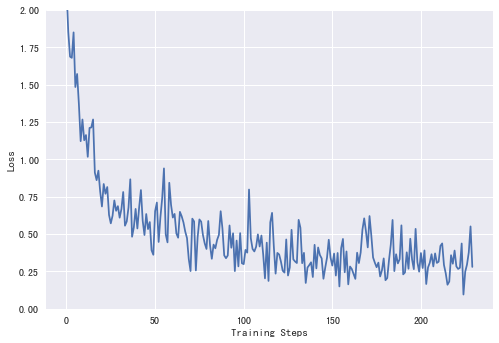

In [33]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

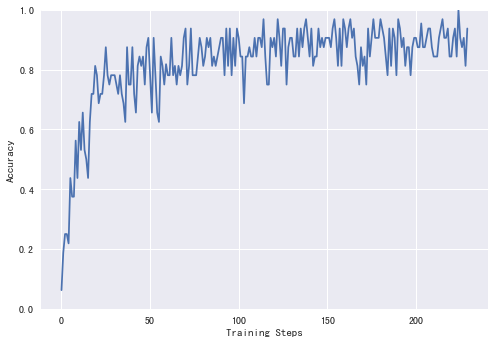

In [34]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [35]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [36]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

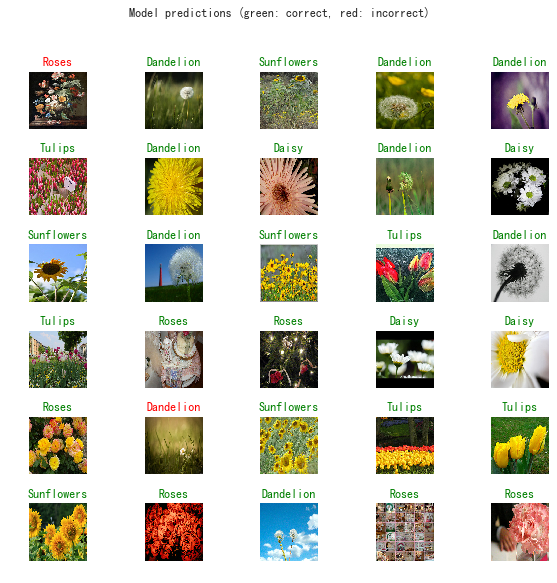

In [38]:
label_id = np.argmax(label_batch, axis=-1)
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(image_batch[i])
    color = "green" if predicted_id[i] == label_id[i] else "red"
    plt.title(predicted_label_batch[i].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (green: correct, red: incorrect)")



In [39]:
# 导出模型

import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0820 16:11:43.669183 4599195072 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0820 16:11:43.670377 4599195072 export_utils.py:182] Export includes no default signature!
W0820 16:11:44.382064 4599195072 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0820 16:11:51.326066 4599195072 export_utils.py:182] Export includes no default signature!
W0820 16:11:52.245558 4599195072 meta_graph.py:450] Issue e

'/tmp/saved_models/1566288695'

In [40]:
# 加载刚刚保存的模型
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
result_batch = model.predict(image_batch)
# 用加载的模型和原来模型预测进行对比
reloaded_result_batch = reloaded.predict(image_batch)

In [43]:
# 无差异
abs(reloaded_result_batch - result_batch).sum()

0.0